In [1]:
%matplotlib inline 
from IPython.display import display, HTML
import pandas as pd 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
import os 
import numpy as np 
import pylab as pl
import scipy.stats as st
import glob 
from ifis_tools import database_tools as db
from ifis_tools import series_tools as ser
import hydroeval as heval

In [2]:
def Read_Qobs(linkID):
    for k in USGS.keys():
        if USGS[k] == linkID:
            USGS_id = k
    Qobs = db.SQL_read_USGS_Streamflow(USGS_id, '2008-1-1','2018-12-31')
    return Qobs['val']
def MedianByInterval(RCobs, RCsim, bins = np.linspace(0,1,6)):
    Ps = [0]
    X = [0]
    for b1,b2 in zip(bins[:-1],bins[1:]):
        pos = np.where((RCobs>b1)&(RCobs<=b2))[0]
        if pos.size>0:
            Ps.append(np.percentile(RCsim[pos], 50))
        else:
            Ps.append(np.nan)
        X.append((b1+b2)/2.)
    return np.array(Ps), np.array(X)

# Tl Analysis.

Here we perform an analysis of $T_l$ vrying its value on the model and evaluating the performance on the model.  Steps follow:

1. Run HLM model with different values of $T_l$:
    - 0.1, 0.09, 0.07, 0.05, 0.03
2. For all links with USGS info, read the data and compare results in terms of:
    - RCobs Vs RCsim dispersion.
    - Nash eff of events.
    - KG eff of events.

In [7]:
path = '/media/nicolas/Data/RunoffExp/Results/'

In [4]:
USGS = db.SQL_USGS_at_IFIS()
Links = [USGS[k] for k in USGS.keys()]

In [5]:
Qobs = {}
Qsim = {}
Events = {}

In [ ]:
%%time
for link in Links:
    try:
        #Observed data 
        qobs = pd.read_msgpack(path + 'USGS/'+str(link)+'.msg')
        Qhlm = pd.read_msgpack(path + 'HLM190/'+str(link)+'.msg')
        Rain = pd.read_msgpack(path + 'Rainfall/'+str(link)+'.msg')
        #Read data and separate flux
        qobs, Qrun, QsepO = ser.Runoff_SeparateBaseflow(qobs, Qhlm)
        #Mean anual maximum 
        Qmax = qobs.resample('A').max().mean()
        Area = db.SQL_Get_linkArea(link)
        #Find events and estimates observed RC
        pos1, pos2 = ser.Runoff_FindEvents(qobs, Qrun, minPeak=Qmax*0.2)
        RCobs = ser.Runoff_CompleteAnalysis(Area, qobs, Rain, QsepO, pos1, pos2, N = pd.Timedelta('2d'))
        #Updates observed dictionary
        Qobs.update({str(link): {'Q':qobs, 'BR': QsepO, 'RC': RCobs['RC'], 'Rain': RCobs['RainEvent']}})
        #Updates dictionary with events 
        Events.update({str(link): {'p1': pos1, 'p2':pos2}})
        
        #Read the model 
        QsimT = {}
        for config in ['01','003','005','007','009']:
            
            #read data and separate baseflow
            qs = pd.read_msgpack(path + 'HLM254/'+str(link)+'_'+config+'.msg')
            qs, Qrun, qsepS = ser.Runoff_SeparateBaseflow(qs, Qhlm)
            #Estimates RunofLf 
            RC = ser.Runoff_CompleteAnalysis(Area, qs, Rain, qsepS, pos1, pos2, N = pd.Timedelta('2d'))
            
            #Eval Overall performance (considering the serie between april and december)
            for ano in range(2012, 2018):
                ind = qs[str(ano)+'-4':str(ano)+'-12'].index
                Ls.extend(qs[str(ano)+'-4':str(ano)+'-12'].values.tolist())
                Lo.extend(qobs.values.tolist())
            NE = heval.evaluator(heval.nse, np.array(Ls),np.array(Lo))[0]
            KG = heval.evaluator(heval.kge, np.array(Ls),np.array(Lo))[0][0]
            
            #Update dictionary with simulations and separated baseflow
            QsimT.update({config: {'Q':qs, 'BR':qsepS, 'RC': RC['RC'], 'NE': NE, 'KG': KG}})
            
            
            
        Qsim.update({str(link): QsimT})
        
       
        
    except:
        pass

In [17]:
RCsim = Qsim['279554']['01']['RC']
RCobs = Qobs['279554']['RC']

(0, 0.5)

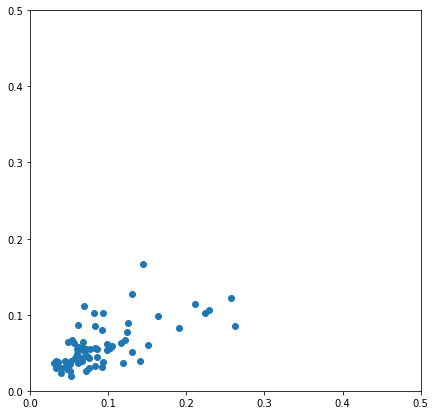

In [26]:
fig = pl.figure(figsize=(7,7))
pl.scatter(RCobs, RCsim)
pl.xlim(0,0.5)
pl.ylim(0,0.5)


In [43]:
Qsim.keys()

dict_keys(['279554', '79118', '399711', '279587', '226574', '378537', '317905', '199722', '272678', '229021', '221201', '465190', '504104', '350386', '203777', '202584', '323529', '221500', '226541', '447887', '197517', '432886', '178416', '522855', '434365', '272942', '318272', '74725', '104818', '314529', '270936', '292251', '367593', '412946', '179425', '406874', '326674', '272783', '448250', '204046', '114284', '426239', '522980', '275929', '92050', '397674', '509679', '216572', '503998', '78279', '278516', '463834', '326618', '504030', '197256', '216714', '367813', '110818', '378268', '522951', '217531', '334449', '92010', '368052', '434478', '450755', '368123', '465030', '273761', '83159', '98104', '230973', '318079', '318225', '487052', '487254', '285449', '227265', '368221', '258321', '378371', '323592', '203920', '273299', '425876', '434514', '425748', '240462', '555865', '437890', '157405', '431052', '426049', '255051', '309414', '197446', '245378', '143605', '230601', '22899